# Via MCMC

The same again, but this time using `emcee` to try to sample via MCMC methods.  This proves to be more difficult than we might except.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches
import numpy as np
import scipy.stats
import lzma, pickle
import pandas as pd
import emcee
import datetime

In [2]:
with lzma.open("case_study_hit_counts.pic.xz") as f:
    hitcounts = pickle.load(f)

# Some general code

In [3]:
def default_initial_conditions(nwalkers=50):
    return np.random.rand(2 * nwalkers).reshape((nwalkers, 2))
    
def run(log_likelihood, data, nwalkers=50, initial=default_initial_conditions):
    sampler = emcee.EnsembleSampler(nwalkers, 2, log_likelihood, args=(data,))
    p0 = initial(nwalkers)
    pos, prob, state = sampler.run_mcmc(p0, 50)
    sampler.reset()
    sampler.run_mcmc(pos, 50000 // nwalkers)
    return sampler
    
def plot_chains(sampler):
    fig, axes = plt.subplots(nrows=2, figsize=(16, 4))
    for i in range(2):
        axes[i].plot(sampler.flatchain[:,i], linewidth=0.5)
    return fig
    
def plot_dists(sampler):
    fig, axes = plt.subplots(ncols=2, figsize=(16,5))
    for i in range(2):
        axes[i].hist(sampler.flatchain[:,i], 100, color="k", histtype="step")
    return fig

def sample_thetas(to_alpha_beta):
    thetas = [np.random.beta(*to_alpha_beta(x)) for x in sampler.flatchain]
    return np.asarray(thetas)

def plot_thetas(thetas):
    fig, ax = plt.subplots(figsize=(8,6))
    bins = np.linspace(0, 1, 100)
    ax.hist(thetas, bins, color="k", histtype="step")
    return fig

def data_likelihood(alpha, beta, data):
    def lg(x):
        return scipy.special.loggamma(x).real
    p = len(data) * (lg(alpha + beta) - lg(alpha) - lg(beta))
    # This could be sped up with numpy magic
    for n, N in data:
        p += lg(alpha + n) + lg(beta + (N - n)) - lg(alpha + beta + N)
    #n, N = (np.asarray(x) for x in zip(*data))
    #p+= np.sum(lg(alpha + n) + lg(beta + (N - n)) - lg(alpha + beta + N))
    return p

# Parameterisations

To start with, we look at [alternate parameterisations](https://en.wikipedia.org/wiki/Beta_distribution#Alternative_parametrizations) of the Beta function, in particular using the mean $\mu = \alpha / (\alpha+\beta)$ and the "sample size" $s = \alpha+\beta$.

Start with using coordinates in $u=\operatorname{logit}(\mu) = \log(\alpha / \beta)$ and $v=\log(s)$.  These transformations map the parameters to $(u,v)\in\mathbb R^2$.

Following Gelman et al. we use the prior distribution $p(u,v) = \alpha\beta(\alpha+\beta)^{-5/2}$

### With 50 walkers

In [151]:
def log_likelihood(x, data):
    """x is (log(alpha/beta), log(alpha+beta))"""
    if np.any(x > 700):
        return -np.inf
    a, b = np.exp(x)
    beta = b / (1 + a)
    alpha = a * beta
    if not np.isfinite(alpha) or not np.isfinite(beta):
        return -np.inf
    p = np.log(alpha) + np.log(beta) - 2.5 * x[1]
    return p + data_likelihood(alpha, beta, data)

data = [v[0][10] for v in hitcounts.values()]
sampler = run(log_likelihood, data)

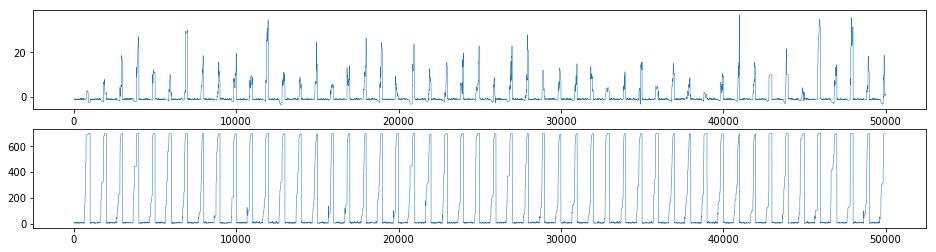

In [152]:
fig = plot_chains(sampler)

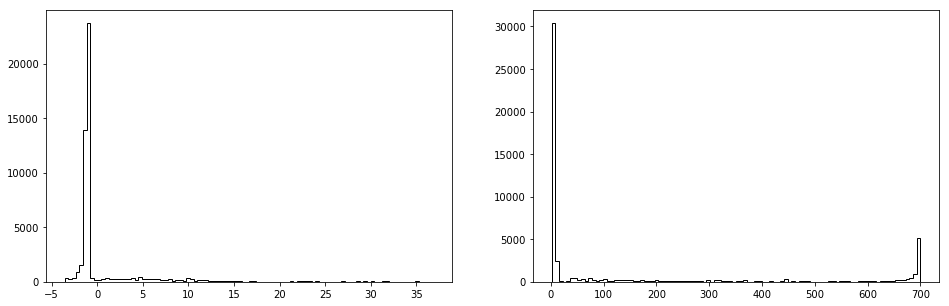

In [153]:
fig = plot_dists(sampler)

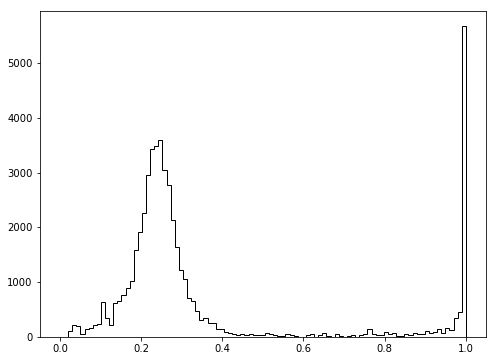

In [154]:
def to_alpha_beta(x):
    a, b = np.exp(x)
    beta = b / (1 + a)
    return a * beta, beta

thetas = sample_thetas(to_alpha_beta)
fig = plot_thetas(thetas)

### 200 walkers

In [155]:
sampler = run(log_likelihood, data, nwalkers=200)

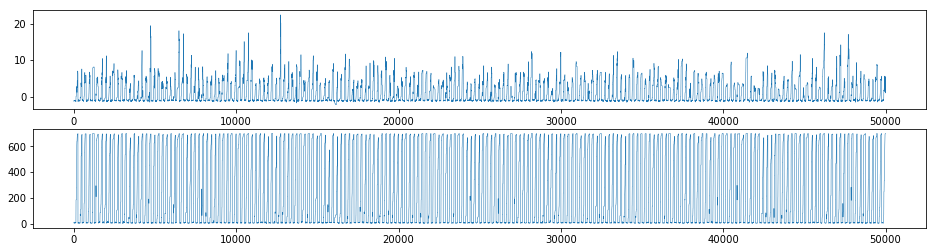

In [156]:
fig = plot_chains(sampler)

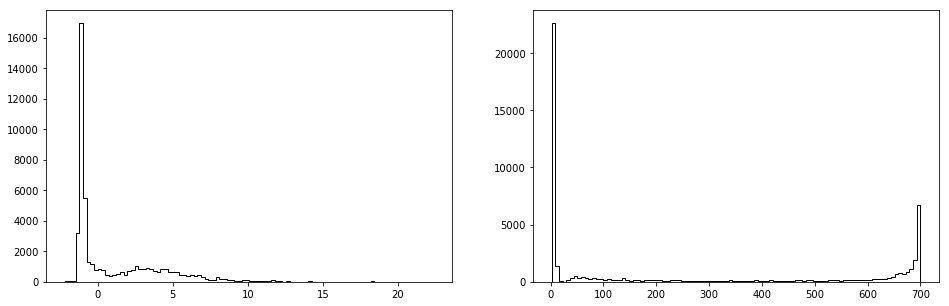

In [157]:
fig = plot_dists(sampler)

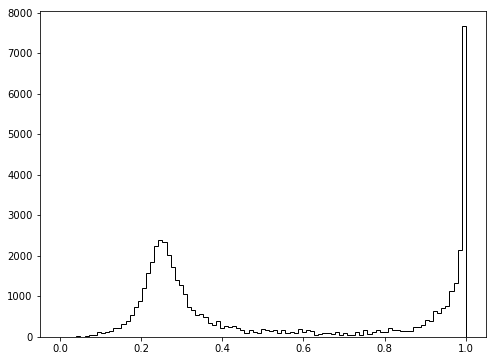

In [158]:
thetas = sample_thetas(to_alpha_beta)
fig = plot_thetas(thetas)

### 1000 walkers

In [159]:
sampler = run(log_likelihood, data, nwalkers=1000)

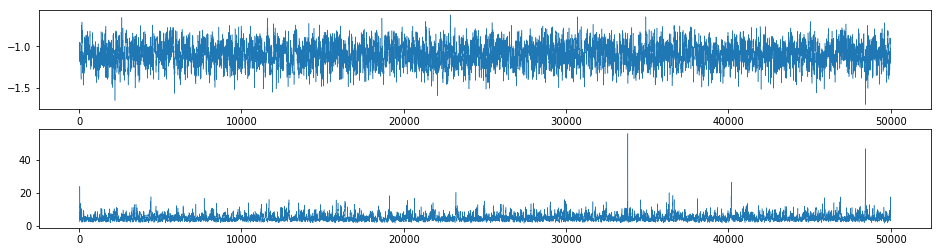

In [160]:
fig = plot_chains(sampler)

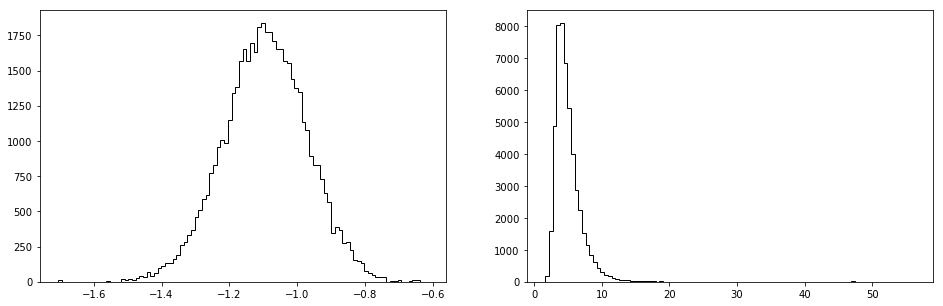

In [161]:
fig = plot_dists(sampler)

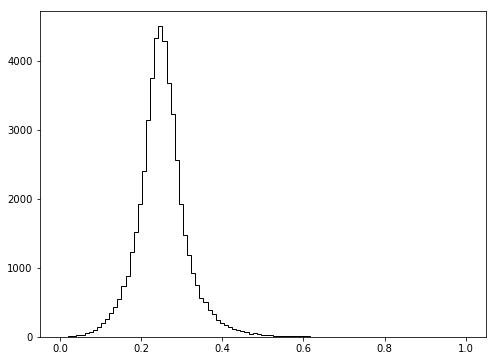

In [162]:
thetas = sample_thetas(to_alpha_beta)
fig = plot_thetas(thetas)

# 2nd parameterisation

Now work in $(\alpha, \beta)$ space.  This seems to work better with `emcee`.

In [29]:
def log_likelihood(x, data):
    """x is (alpha, beta)"""
    x = np.asarray(x)
    if np.any(x <= 0):
        return -np.inf
    alpha, beta = x
    p = -2.5 * np.log(alpha + beta)
    return p + data_likelihood(alpha, beta, data)
    
def to_alpha_beta(x):
    return tuple(x)
    
data = [v[0][10] for v in hitcounts.values()]
sampler = run(log_likelihood, data)

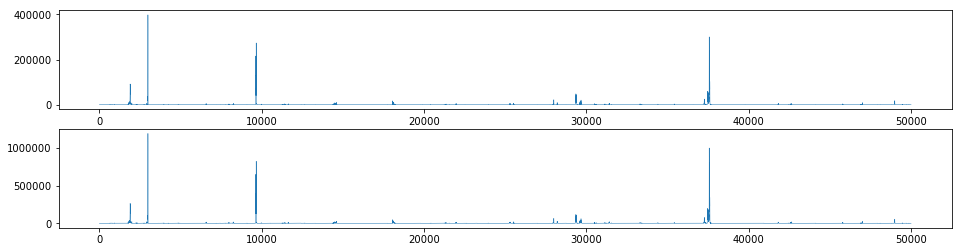

In [30]:
fig = plot_chains(sampler)

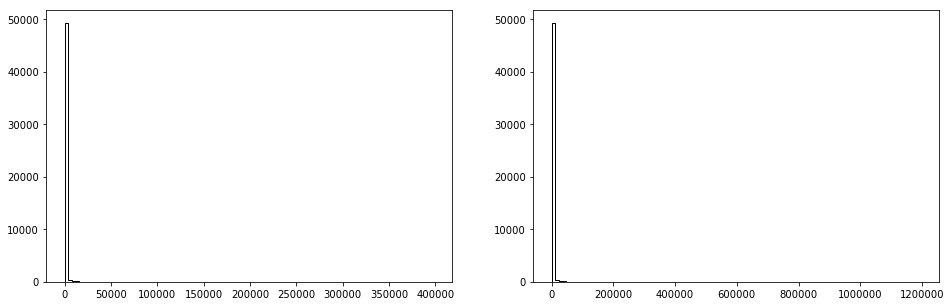

In [31]:
fig = plot_dists(sampler)

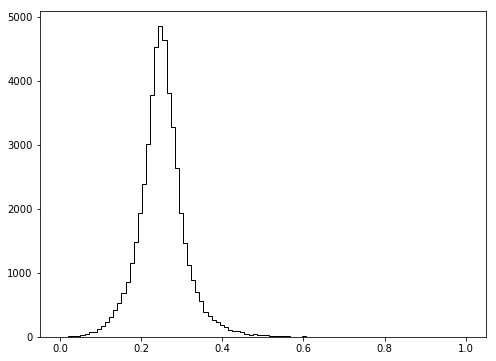

In [32]:
thetas = sample_thetas(to_alpha_beta)
fig = plot_thetas(thetas)

In [33]:
def postive_initial(nwalkers):
    return np.random.exponential(10, 2 * nwalkers).reshape((nwalkers, 2))

sampler = run(log_likelihood, data, initial=postive_initial)

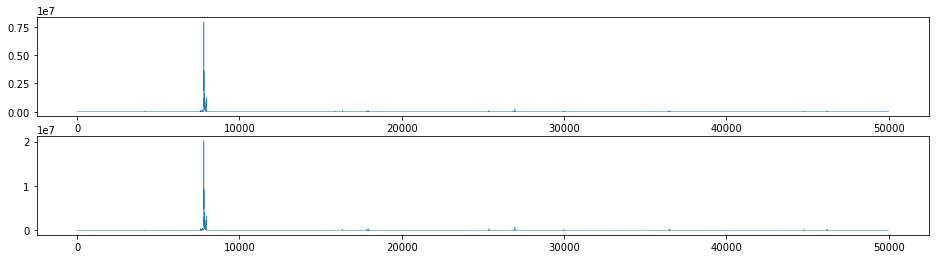

In [34]:
fig = plot_chains(sampler)

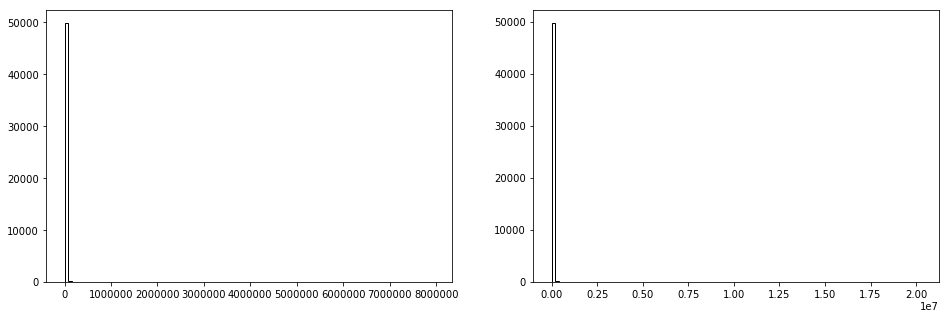

In [35]:
fig = plot_dists(sampler)

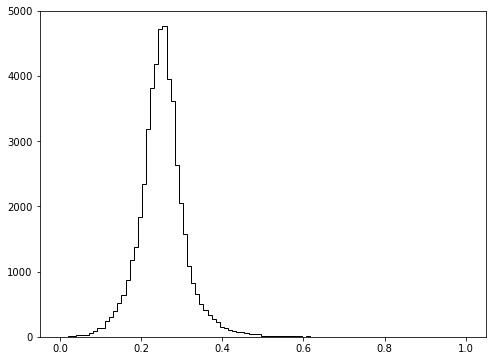

In [36]:
thetas = sample_thetas(to_alpha_beta)
fig = plot_thetas(thetas)

# Uniform

We should be able to get the same result with the uniform on $(\mu, s^{-1/2})$.

Don't really understand why this doesn't work...

In [163]:
def log_likelihood(x, data):
    """x is (alpha/(alpha+beta), (alpha+beta)^{-1/2}"""
    x = np.asarray(x)
    if x[0] <= 0 or x[0] >= 1 or x[1] <= 0:
        return -np.inf
    ab = 1 / x[1]*x[1]
    alpha = x[0] * ab
    beta = (1 - x[0]) * ab
    return data_likelihood(alpha, beta, data)
    
def to_alpha_beta(x):
    ab = 1 / x[1]*x[1]
    alpha = x[0] * ab
    beta = ab - alpha
    return alpha, beta
    
data = [v[0][10] for v in hitcounts.values()]
sampler = run(log_likelihood, data)

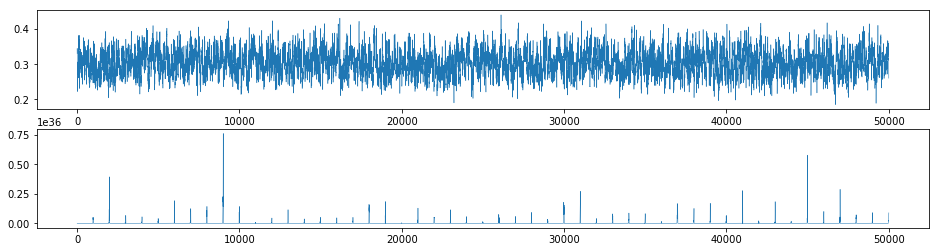

In [164]:
fig = plot_chains(sampler)

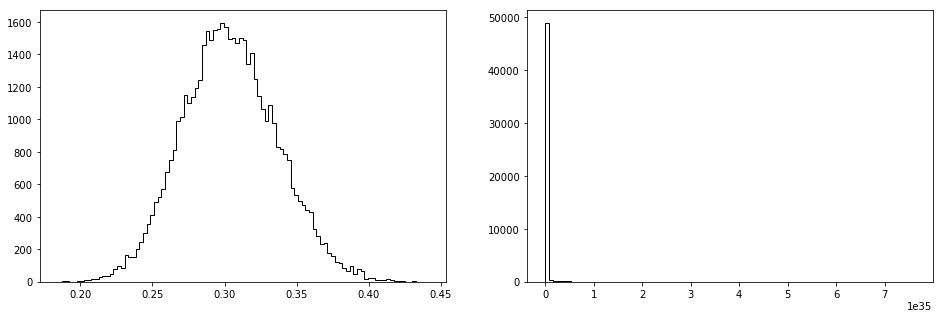

In [165]:
fig = plot_dists(sampler)

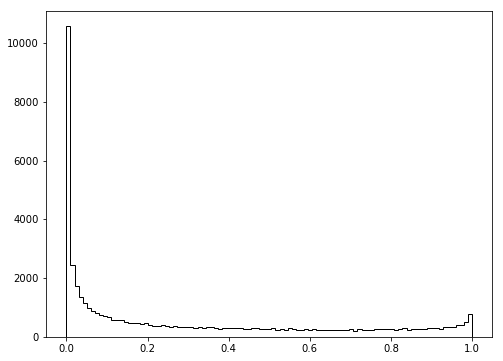

In [166]:
thetas = sample_thetas(to_alpha_beta)
fig = plot_thetas(thetas)

In [54]:
sampler = run(log_likelihood, data, nwalkers=250)

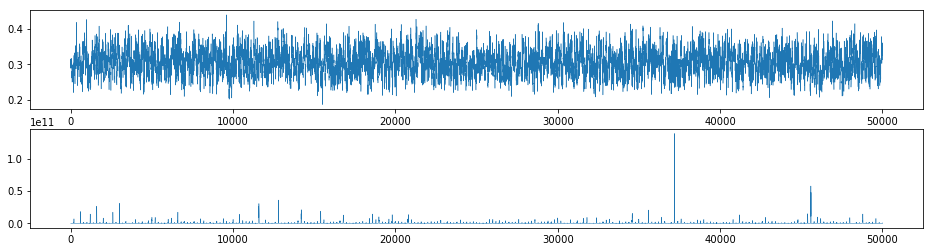

In [55]:
fig = plot_chains(sampler)

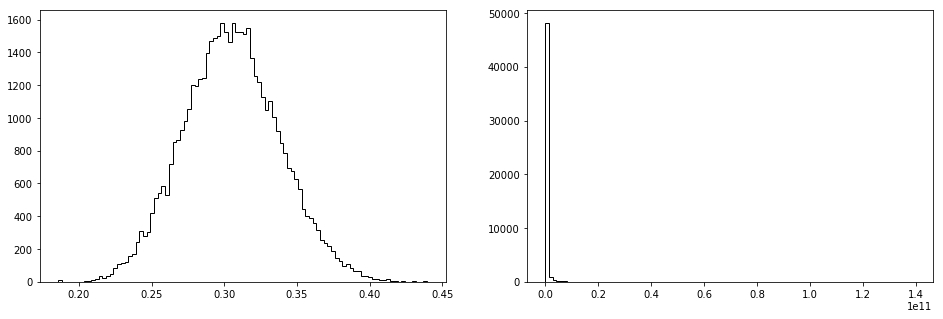

In [56]:
fig = plot_dists(sampler)

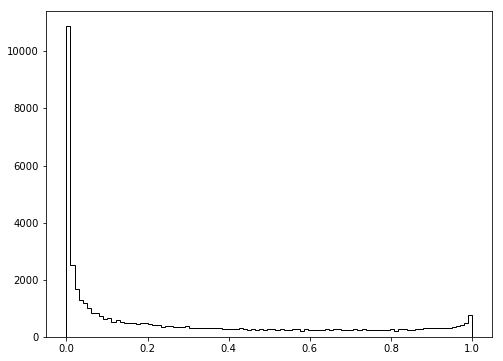

In [57]:
thetas = sample_thetas(to_alpha_beta)
fig = plot_thetas(thetas)

In [58]:
sampler = run(log_likelihood, data, nwalkers=1000)

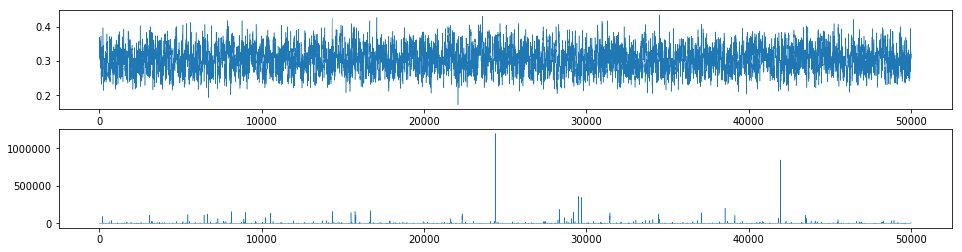

In [59]:
fig = plot_chains(sampler)

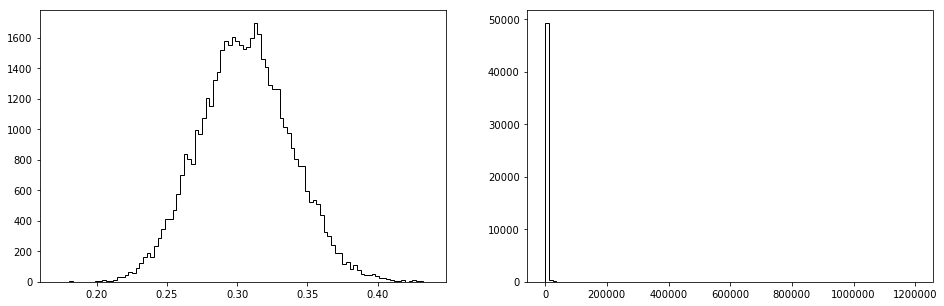

In [60]:
fig = plot_dists(sampler)

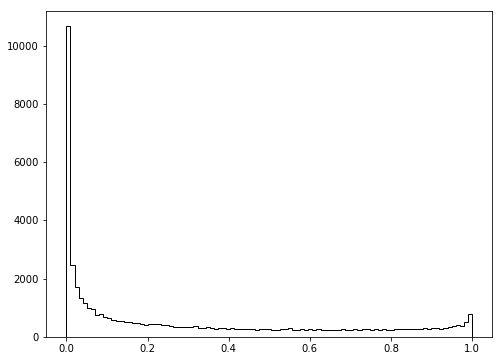

In [61]:
thetas = sample_thetas(to_alpha_beta)
fig = plot_thetas(thetas)

# Exponential Prior

Problem is that I think this is not a natural parameterisation

In [108]:
def log_likelihood(x, data):
    alpha, beta = x
    if alpha <= 0 or beta <= 0:
        return -np.inf
    p = -np.log(alpha) * 0.1 - np.log(beta) * 0.1
    return p + data_likelihood(alpha, beta, data)
    
def to_alpha_beta(x):
    return tuple(x)
    
data = [v[0][10] for v in hitcounts.values()]
sampler = run(log_likelihood, data, nwalkers=200)

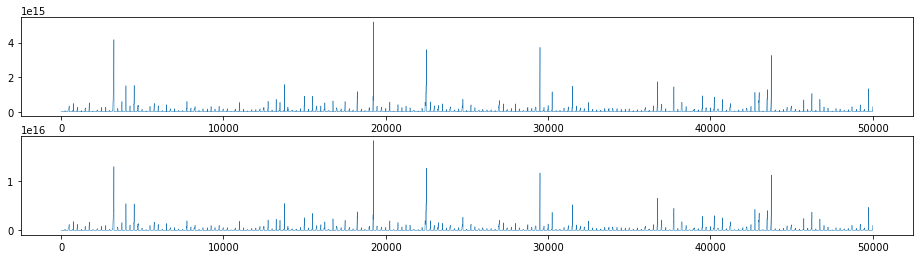

In [109]:
fig = plot_chains(sampler)

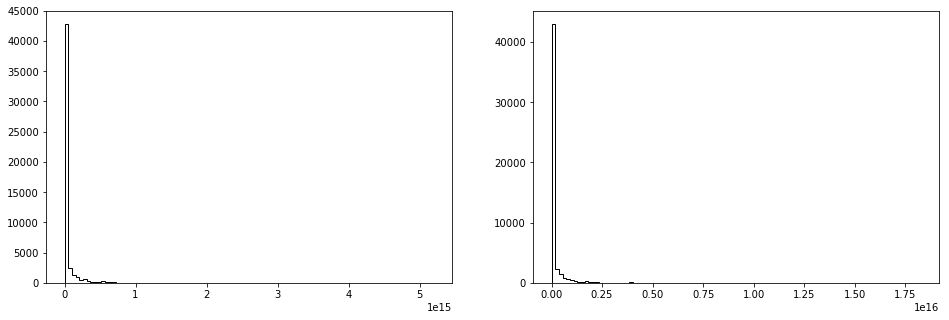

In [110]:
fig = plot_dists(sampler)

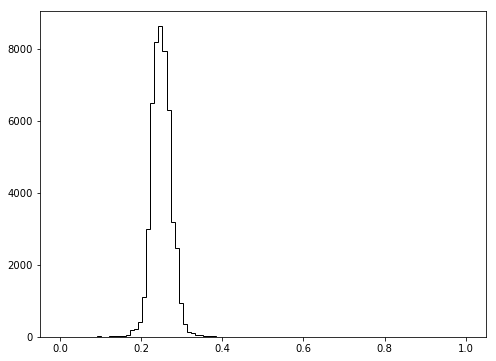

In [111]:
thetas = sample_thetas(to_alpha_beta)
fig = plot_thetas(thetas)

In [120]:
def log_likelihood(x, data):
    mean, samples = x
    alpha = mean * samples
    beta = (1 - mean) * samples
    if alpha <= 0 or beta <= 0:
        return -np.inf
    p = -np.log(samples / 100)
    return p + data_likelihood(alpha, beta, data)
    
def to_alpha_beta(x):
    mean, samples = x
    alpha = mean * samples
    beta = (1 - mean) * samples
    return alpha, beta
    
data = [v[0][10] for v in hitcounts.values()]
sampler = run(log_likelihood, data, nwalkers=200)

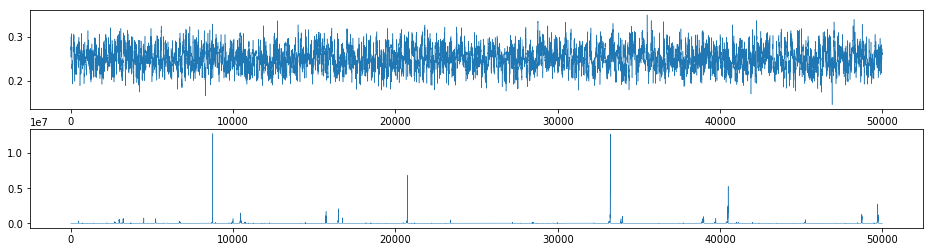

In [121]:
fig = plot_chains(sampler)

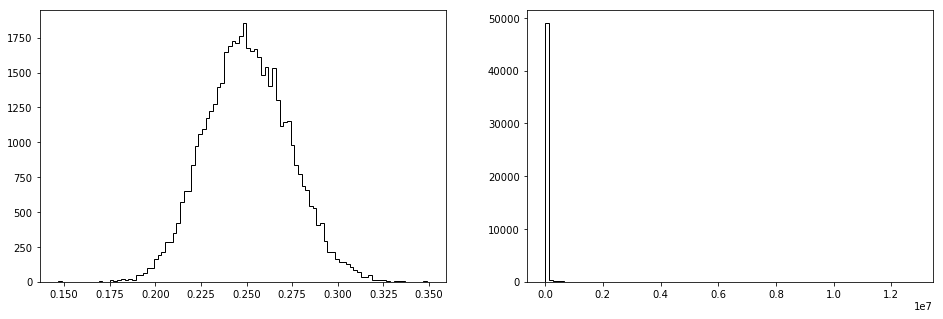

In [122]:
fig = plot_dists(sampler)

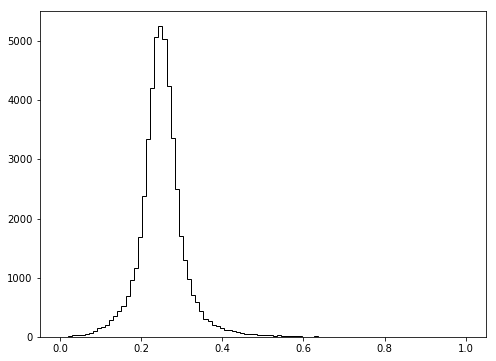

In [123]:
thetas = sample_thetas(to_alpha_beta)
fig = plot_thetas(thetas)

# Exponential in samples

We parameterise by the mean $\alpha / (\alpha + \beta)$ and the "number of examples $(\alpha+\beta)$.  We put the uniform measure on the mean, and an exponential with very slow decay on the number of samples.

In [147]:
def log_likelihood(x, data):
    mean, samples = x
    alpha = mean * samples
    beta = (1 - mean) * samples
    if alpha <= 0 or beta <= 0:
        return -np.inf
    p = -np.log(samples / 10000)
    return p + data_likelihood(alpha, beta, data)
    
def to_alpha_beta(x):
    mean, samples = x
    alpha = mean * samples
    beta = (1 - mean) * samples
    return alpha, beta
    
data = [v[0][10] for v in hitcounts.values()]
sampler = run(log_likelihood, data, nwalkers=200)

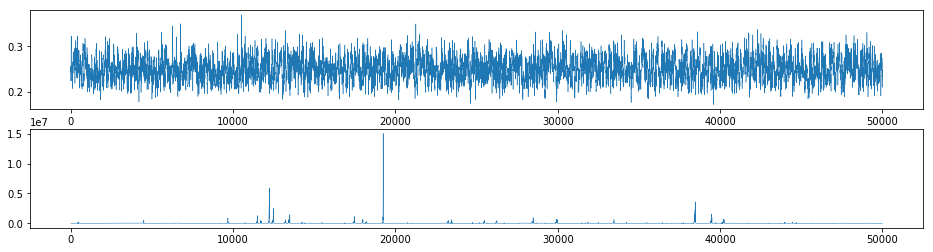

In [148]:
fig = plot_chains(sampler)

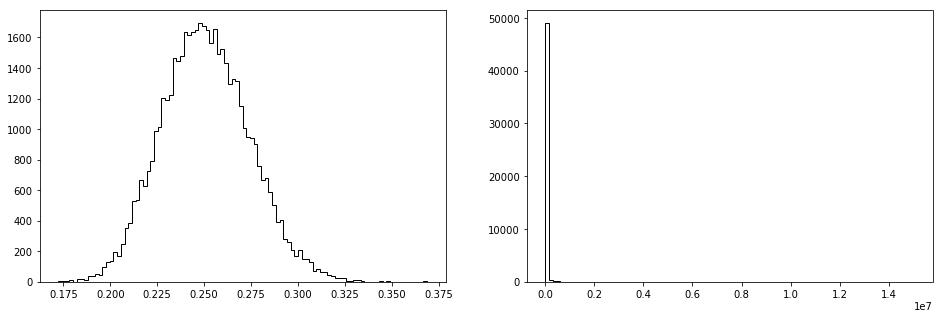

In [149]:
fig = plot_dists(sampler)

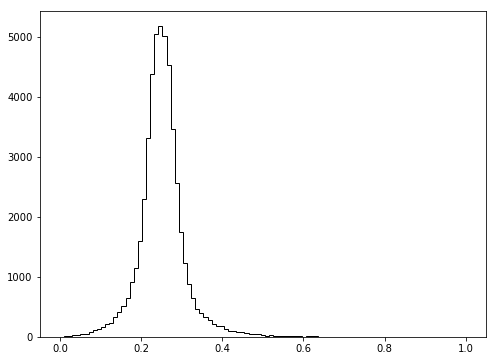

In [150]:
thetas = sample_thetas(to_alpha_beta)
fig = plot_thetas(thetas)

# In alpha beta space

In [143]:
def log_likelihood(x, data):
    alpha, beta = x
    if alpha <= 0 or beta <= 0:
        return -np.inf
    samples = alpha + beta
    p = -np.log(samples / 10000) - np.log(samples)
    return p + data_likelihood(alpha, beta, data)
    
def to_alpha_beta(x):
    return tuple(x)
    
data = [v[0][10] for v in hitcounts.values()]
sampler = run(log_likelihood, data, nwalkers=100)

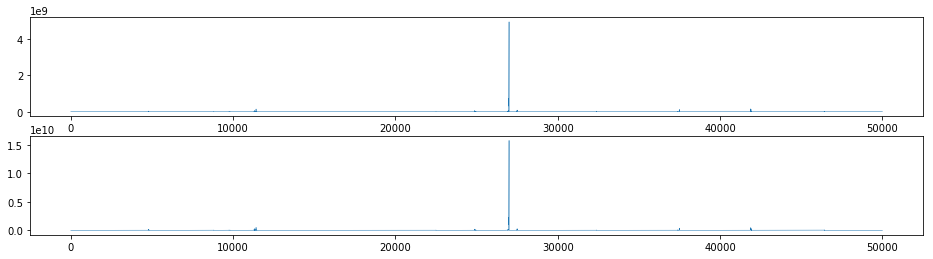

In [144]:
fig = plot_chains(sampler)

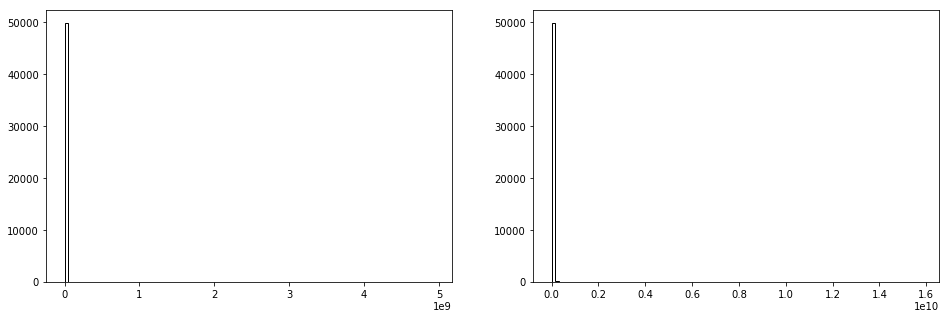

In [145]:
fig = plot_dists(sampler)

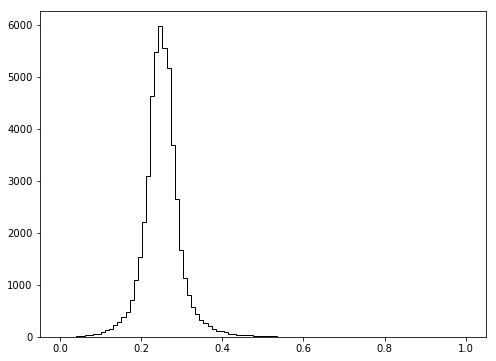

In [146]:
thetas = sample_thetas(to_alpha_beta)
fig = plot_thetas(thetas)